# Práctica 2. Aprendizaje por refuerzo
## Inteligencia Artificial I    2022/2023

Grupo XX


## Parte 1. Taxi
Vamos a utilizar como primer ejemplo un entorno de jugete de la librería Gym 

https://www.gymlibrary.dev/environments/toy_text/taxi/

Tenemos una rejilla rectangular con 4 ubicaciones (etiquetadas con letras diferentes) y nuestro trabajo es recoger al pasajero en una ubicación y dejarlo en otra. Se trata de llevar al pasajero que inicialmente está en Y (0,4) a la posición destino R (0,0). El taxi solo puede coger y dejar pasajeros en las posiciones marcadas.
Recibimos +20 puntos por dejar al pasajero con éxito y perderemos 1 punto por cada paso. También hay una penalización de 10 puntos por acciones ilegales de recoger y dejar.

En la librería OpenAI's Gym tenemos definido el modelo de este entorno de pruebas (Taxi) y podemos desarrollar y evaluar nuestro agente que aprende usando RL. La librería gym nos proporciona la representación y la visualización (render) del tablero por lo que no tenemos que hacerlo (aunque sería sencillo representarlo en AIMA y resolverlo con cualquiera de sus algoritmos de búsqueda). 

In [1]:
# Para el ejemplo del taxi y el cart pool es necesario instalar algunas librerías (gym,cmake,scipy) si no están ya instaladas
# !pip install cmake
# La librería gym proporciona problemas de prueba — environments — con una interfaz general que puedes usar para probar 
# distintos algoritmos y configuraciones de RL. 

# !pip install gym
#!pip install ale-python-interface
#!pip install gym --force-reinstall --user
# tps://gym.openai.com/docs/

##!pip install scipy
import sys 
!{sys.executable} -m pip install cmake
import sys 
!{sys.executable} -m pip install scipy
import sys
!{sys.executable} -m pip install gym
import sys
!{sys.executable} -m pip install pygame

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.3/23.3 MB 3.0 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.9/21.9 MB 3.3 MB/s eta 0:00:00m eta 0:00:010:00:01

[notice] A new release of pip available: 22.1.2 -> 22.3
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import random
import gym
env = gym.make("Taxi-v3").env
# Taxi environment con la visualización por defecto
#env = gym.make('Taxi-v3',render_mode="human")
#env = gym.make('Taxi-v3',render_mode="rgb_array")
#env = gym.make('Taxi-v3',render_mode="ansi")
#env.render() 
# El render explícito da error en la ultima version de gym. 
# Hay que especificar el modo de render al hacer make y se hace automático. 

La interfaz principal del entorno gym es env. 
Vamos a utilizar los siguientes métodos de env:

- env.reset: restablece el entorno y devuelve un estado inicial aleatorio.

- env.step (acción): realiza un paso en el entorno. Devuelve:

      observación: estado siguiente del entorno al aplicar la acción
      recompensa: asociada a la acción en ese estado
      done: Indica fin del episodio por éxito (hemos recogido y dejado a un pasajero)
      info: información adicional como rendimiento y latencia para depuración
      
- env.render: renderiza el entorno (útil para visualizar el entorno)

In [3]:
# creamos e inicializamos el entorno 
env = gym.make('Taxi-v3', render_mode="human")
observation = env.reset()
# ejecuto una acción aleatoria
action = env.action_space.sample()
env.step(action)
env.close() # IMPORTANTE

In [ ]:
        canibales_alla  = 3 - canibales_aqui# Al ejecutar este fragmento de código veremos 20 episodios del tablero del taxi. 
# En cada episodio se prueban 10 acciones aleatorias.
env = gym.make('Taxi-v3',render_mode="human")
for i_episode in range(20):
    observation = env.reset() #devuelve  un estado inicial aleatorio.
    for t in range(10):
        #print("estado {}".format(observation))
        action = env.action_space.sample()  # acción aleatoria.
        #print("action {}".format(action))
        observation, reward, done, info, X = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break       
    print("Episodio terminado sin éxito")
env.close()

Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito
Episodio terminado sin éxito


In [ ]:
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

El Action Space tiene tamaño 6 y el State Space tiene tamaño 500. El algoritmo RL no necesita más información que estas dos cosas. Todo lo que necesitamos es una forma de identificar un estado de forma única asignando un número único a cada estado posible, y RL aprende a elegir un número de acción de 0 a 5 donde:
   - 0 = sur
   - 1 = norte
   - 2 = este
   - 3 = oeste
   - 4 = recoger
   - 5 = dejar

Los 500 estados corresponden a una codificación de la ubicación del taxi, la ubicación del pasajero y la ubicación de destino.

El aprendizaje por refuerzo aprenderá un mapeo de estados con la acción óptima a realizar en ese estado. Para ello realizaremos un proceso de exploración, es decir, el agente explora el entorno y toma acciones basadas en las recompensas definidas en el entorno. La acción óptima para cada estado es la acción que tiene la mayor recompensa acumulativa a largo plazo según la fórmula vista para el Q-learning.

Dado el estado representado en la imagen anterior, vamos a codificar su estado y dárselo al entorno para que se renderice en Gym. 
Las filas y columnas se numeran de 0 a 4 y, como se ve en la imagen, tenemos el taxi en la fila 3, columna 1, nuestro pasajero está en la ubicación 2 y nuestro destino es la ubicación 0:  R (0), G (1), Y (2), B (3)

Usando el método de codificación de estado Taxi-v3, podemos hacer lo siguiente:

In [ ]:
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)
env.s = state

In [ ]:
# La función print_frames la usaremos para visualizar los estados en modo texto.
from IPython.display import clear_output
from time import sleep

def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        #print(frame['frame'].getvalue())
        print(frame['frame'])
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.2)

In [ ]:
env = gym.make('Taxi-v3',render_mode="ansi")
env.reset()
env.s=state
action = env.action_space.sample()
state, reward, done, info, x = env.step(action)
frame = [] 
frame.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        })


In [ ]:
# En este caso solo mostramos un estado
print_frames(frame)

Podemos asertar las posiciones en el estado con env.encode() o usar los números entre 0 y 499 que son los 500 estados válidos en el espacio de estados. 

En la visualización anterior:
- El cuadrado representa el taxi, que es amarillo sin pasajero y verde con pasajero.
- La marca ("|") representa una pared que el taxi no puede cruzar.
- R, G, Y, B son las posibles ubicaciones de recogida y destino. La letra azul representa la ubicación actual de recogida de pasajeros y la letra morada es el destino actual.

In [ ]:
env.s = 499
action = env.action_space.sample()
state, reward, done, info, x = env.step(action)
frame = [] 
frame.append({
        'frame': env.render(),
        'state': env.s,
        'action': action,
        'reward': reward
        })
print_frames(frame)

In [ ]:
# Hay una tabla (diccionario) P del entorno 
# Es equivalente a la matriz R que hemos visto en clase, pero tiene más informacion.
#podemos ver los valores de reward asignados por defecto al estado 328 que usamos como ejemplo
env.P[328]

Este diccionario tiene la siguiente estructura {acción: [(probabilidad, próximo estado, recompensa, hecho)]}.

- El valor de 0-5 corresponde a las acciones (sur, norte, este, oeste, recogida, entrega) que el taxi puede realizar.
- La probabilidad es siempre 1.0 (en este entorno)
- nextstate muestra el estado siguiente usando la acción en este índice del diccionario.
- Las acciones de movimiento tienen por defecto una recompensa de -1 y pickup / dropoff tiene -10 Si estuvimos en un estado donde el taxi tiene un pasajero y estamos en la posición destino correcta se vería una recompensa de 20 en la action dropoff (5 ))
- done se utiliza para indicarnos cuándo hemos dejado a un pasajero en el lugar correcto. Cada dejada de un pasajero (dropoff) con éxito es el final de un episodio.

Hay que tener en cuenta que si nuestro agente eligiera explorar la acción dos (2) en este estado, iría hacia el este y chocaría contra una pared. El código fuente ha hecho imposible mover el taxi a través de una pared, por lo que si el taxi elige esa acción, seguirá acumulando -1 penalizaciones, lo que afecta la recompensa a largo plazo.

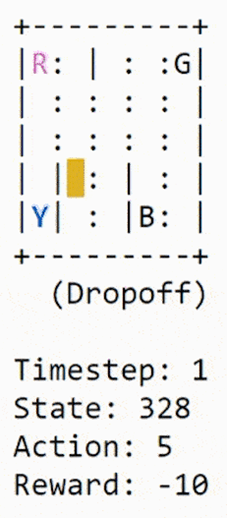

### Paso 1. Resolvemos el problema sin aprendizaje por refuerzo

Una vez que hemos entendido el modelo del entorno, veamos qué pasaría si intentamos utilizar la fuerza bruta para resolver el problema sin RL.
Dado que tenemos nuestra tabla P para las recompensas predeterminadas en cada estado, podemos intentar que nuestro taxi navegue solo con eso.
Crearemos un bucle infinito que se ejecutará hasta que un pasajero llegue a un destino (un episodio), o en otras palabras, cuando la recompensa recibida sea 20.

El método env.action_space.sample () selecciona automáticamente una acción aleatoria del conjunto de todas las acciones posibles.


In [ ]:
action = env.action_space.sample()
action

In [ ]:
env = gym.make('Taxi-v3',render_mode="ansi")
#env.s = 328  # podemos fijar un estado inicial (por ejemplo el estado 328) o un estado aleatorio con reset
env.reset()

epochs = 0
penalties, reward = 0, 0

frames = [] # for animation

done = False

while not done:
    action = env.action_space.sample()
    state, reward, done, info, x = env.step(action)

    if reward == -10:
        penalties += 1
    
    # Put each rendered frame into dict for animation
    frames.append({
        'frame': env.render(),
        'state': state,
        'action': action,
        'reward': reward
        }
    )

    epochs += 1
    
    
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))


In [ ]:
print_frames(frames)

El agente va a ciegas y utiliza miles de pasos de tiempo y realiza muchos drop-offs incorrectos para entregar un solo pasajero al destino correcto (cuando acierta de casualidad).  

Os dejo como ejercicio opcional la resolución de este problema con cualquiera de los algoritmos de búsqueda de AIMA. Simplemente hay que definir la clase Problem haciendo llamadas a env. 
Usando la codificación numérica de los estados de este entorno y las 5 acciones que hemos visto haciendo una llamada a next_state, reward, done, info = env.step(action) 

Vamos a resolverlo aquí con Aprendizaje por refuerzo que empieza haciendo ciclos a ciegas y aprende de la experiencia pasada.  Cuando "por casualidad" acertamos el agente guarda en la memoria (en forma de recompensa) qué acción fue la mejor para cada estado. Así en el futuro elegirá esa acción. 

In [ ]:
import gym
env = gym.make("Taxi-v3").env
# Estado inicial aleatorio
env.reset() # reset environment to a new, random state   EStado inicial aleatorio 
# O estado inicial establecido 
state = env.encode(3, 1, 2, 0) # (taxi row, taxi column, passenger index, destination index)
print("State:", state)
env.s = state

In [ ]:
state = env.encode(3, 1, 2, 0)     # 3,1 son as coordenadas del taxi.  
# 2 y 0 son las posiciones del pasajero y dejada del pasajero que estan numeradas de 0..4
#  passenger index, destination index  (creo que para indicar que esta en el taxi se usa tambien .. mirar.)

action = env.action_space.sample()    # genera una acción aleatoria
# Recordamos las acciones: 0 = south; 1 = north; 2 = east; 3 = west; 4 = pickup; 5 = dropoff
next_state, reward, done, info, X = env.step(action) 
print("State:", state)
print("Action:", action)

In [ ]:
#next_state = env.step(action)[0] 
print("Next State:", next_state)
env.s = next_state

In [ ]:
action = 5   
# Recordamos las acciones: 0 = south; 1 = north; 2 = east; 3 = west; 4 = pickup; 5 = dropoff
next_state, reward, done, info, X = env.step(action) 
print("State:", state)
print("Next Action:", action)

In [ ]:
print("Next State:", next_state)
env.s = next_state

# como hacemos dropoff de un taxi vacio no hace nada

In [ ]:
env.s = 300
state = env.s
next_state = 0
action = 3   
next_state, reward, done, info,X = env.step(action) 
print("State:", state)
print("Next Action:", action)
print("Next State:", next_state)

### Aprendizaje por refuerzo

Vamos a utilizar el algoritmo de Q-learning que hemos visto en clase y que le dará a nuestro agente algo de memoria.
Básicamente, Q-learning permite al agente utilizar las recompensas del entorno para aprender, con el tiempo, la mejor acción a realizar en un estado determinado.
En nuestro entorno de Taxi, tenemos la tabla de recompensas, P, de la que el agente aprenderá. Lo hace buscando recibir una recompensa por realizar una acción en el estado actual y luego actualizar un valor Q para recordar si esa acción fue beneficiosa.
Los valores almacenados en la tabla Q se denominan valores Q y se asignan a una combinación (estado, acción).
Un valor Q para una combinación de acción de estado particular es representativo de la "calidad" de una acción tomada desde ese estado. Mejores valores Q implican mejores posibilidades de obtener mayores recompensas.
Por ejemplo, si el taxi se enfrenta a un estado que incluye a un pasajero en su ubicación actual, es muy probable que el valor Q para la recogida sea más alto en comparación con otras acciones, como la bajada o el norte.
Los valores Q se inicializan a un valor arbitrario y, a medida que el agente se expone al entorno y recibe diferentes recompensas al ejecutar diferentes acciones, los valores Q se actualizan mediante la ecuación:

Q (estado, acción) ← (1 − α) Q (estado, acción) + α (recompensa + γ max Q (siguiente estado, todas las acciones))

Dónde:
- α (alfa) es la tasa de aprendizaje (0 <α≤1) 
     - Al igual que en los entornos de aprendizaje supervisado, α es la medida en que nuestros valores Q se actualizan en cada iteración.
- γ (gamma) es el factor de descuento (0≤γ≤1) 
    - Determina cuánta importancia queremos dar a las recompensas futuras. Un valor alto para el factor de descuento (cercano a 1) captura la recompensa efectiva a largo plazo, mientras que un factor de descuento de 0 hace que nuestro agente considere solo la recompensa inmediata.

En la fórmula anterior estamos asignando (←), o actualizando, el valor Q del estado actual y la acción del agente tomando primero un peso (1 − α) del antiguo valor Q y luego agregando el valor aprendido. El valor aprendido es una combinación de la recompensa por realizar la acción actual en el estado actual y la recompensa máxima descontada del siguiente estado en el que estaremos una vez que realicemos la acción actual.
Básicamente, estamos aprendiendo la acción adecuada a tomar en el estado actual al observar la recompensa por la combinación estado / acción actual y las recompensas máximas para el siguiente estado. Esto eventualmente hará que nuestro taxi considere la ruta con las mejores recompensas.
El valor Q de un par estado-acción es la suma de la recompensa instantánea y la recompensa futura descontada (del estado resultante). La forma en que almacenamos los valores Q para cada estado y acción es a través de una tabla Q

La tabla Q es una matriz donde tenemos una fila para cada estado (500) y una columna para cada acción (6). Primero se inicializa a 0 y luego los valores se actualizan después del entrenamiento. Tenga en cuenta que la Q-table tiene las mismas dimensiones que la mesa de recompensas, pero tiene un propósito completamente diferente.

En la siguiente figura los valores de la Q-Table se inicializan a cero y se van actualizando durante el aprendizaje.  Los valores optimizan el recorrido del agente a traves del entorno buscando las máximas recompensas. 

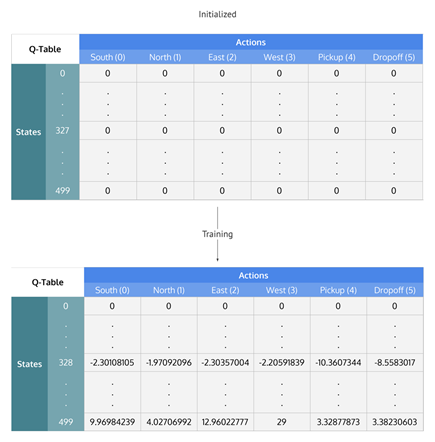

### Resumen del proceso de Q-Learning

    • Inicializar la tabla Q a todo ceros.
    • Comenzar a explorar acciones: para cada estado, seleccione cualquiera de las posibles acciones para el estado actual (S).
    • Ir al siguiente estado (S ') como resultado de esa acción (a).
    • Para todas las acciones posibles del estado (S '), seleccione la que tenga el valor Q más alto.
    • Actualizar los valores de la tabla Q utilizando la ecuación.
    • Establecer el siguiente estado como el estado actual.
    • Si se alcanza el estado objetivo, finalizar y repetir el proceso.

### Explotación de valores aprendidos

Después de una fase de exploración aleatoria de acciones, los valores Q tienden a converger sirviendo a nuestro agente como una función de valor de acción que puede explotar para elegir la acción mejor para un estado dado.
Existe una compensación entre exploración (elegir una acción aleatoria) y explotación (elegir acciones basadas en valores Q ya aprendidos). Queremos evitar que la acción siga siempre la misma ruta y posiblemente se sobreajuste, por lo que introduciremos otro parámetro llamado ϵ "épsilon" para atender esto durante el entrenamiento.
En lugar de simplemente seleccionar la acción de valor Q mejor aprendida, a veces preferimos explorar más el espacio de acción. Un valor de épsilon más bajo da como resultado episodios con más penalizaciones (en promedio), lo cual es obvio porque estamos explorando y tomando decisiones al azar.

In [ ]:
# Primero se inicializa la Q-table a 500×6 matrix of zeros:
import numpy as np
q_table = np.zeros([env.observation_space.n, env.action_space.n])

Ejecutar el aprendizaje es un proceso lento pero se realiza una única vez. 
Una vez entrenado, podemos resolver cualquier problema de este entorno simplemente consultando la tabla y eligiendo la acción que maximiza la recompensa en cada paso (explotación). 
El algoritmo de entrenamiento que actualizará esta Q-table a medida que el agente explora el entorno durante miles de episodios. 

En la primera parte del bucle (while not done) decidimos si elegir una acción aleatoria o explotar los valores Q ya calculados. Esto se hace simplemente usando el valor épsilon y comparándolo con la función random.uniform (0, 1), que devuelve un número arbitrario entre 0 y 1.
Ejecutamos la acción elegida en el entorno para obtener el next_state y la recompensa por realizar la acción. Después de eso, calculamos el valor Q máximo para las acciones correspondientes al next_state, y con eso, podemos actualizar fácilmente nuestro valor Q al new_q_value:

In [ ]:
env.reset()
state = env.s
state

In [ ]:
%%time
"""Training the agent"""

import random
from IPython.display import clear_output

# Hyperparameters
alpha = 0.1
gamma = 0.6
epsilon = 0.1

# For plotting metrics
all_epochs = []
all_penalties = []

for i in range(1, 100001):
    env.reset()
    state = env.s

    epochs, penalties, reward, = 0, 0, 0
    done = False
    
    while not done:
        if random.uniform(0, 1) < epsilon:
            action = env.action_space.sample() # Explore action space
        else:
            action = np.argmax(q_table[state]) # Exploit learned values

        next_state, reward, done, info, X = env.step(action) 
        
        old_value = q_table[state, action]
        next_max = np.max(q_table[next_state])
        
        new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
        q_table[state, action] = new_value

        if reward == -10: #Pickup/dropoff illegally
            penalties += 1

        state = next_state
        epochs += 1
        
    if i % 100 == 0:
        #clear_output(wait=True)
        print(f"Episode: {i}")

print("Training finished.\n")


In [ ]:
# La tabla Q ha cambiado despues de 100000 episodios. Vamos a ver cuales son los Q-values aprendidos en el estado de ejemplo. 
q_table[328]

In [ ]:
## Añadimos una funcion para visualizar un estado usando print_frames
def print_taxi_state(state):
    env = gym.make('Taxi-v3', render_mode="ansi")
    env.reset()
    env.s = state
    ## Invocamos la funcion print_frames
    frame = []
    frame.append({
        'frame': env.render(),
        'state': state,
        'action': 0,
        'reward': 0
    })
    print_frames(frame)

# Vamos a ver el estado 328
print_taxi_state(328)

Observa el valor máximo de Q en el estado 328. ¿Te parece que Q-learning ha aprendido efectivamente la mejor acción a realizar en este estado?

TODO:Responder a la pregunta.

### Evaluar el comportamiento del agente despues del proceso de Q-learning 

Para evaluar el comportamiento de nuestro agente no necesitamos explorar más acciones. En el comportamiento del agente ahora la siguiente acción siempre se selecciona utilizando el mejor valor Q:

In [ ]:
total_epochs, total_penalties = 0, 0
episodes = 100
env = gym.make("Taxi-v3").env

for _ in range(episodes):
    env.reset()
    state = env.s
    epochs, penalties, reward = 0, 0, 0
    
    done = False
    
    while not done:
        action = np.argmax(q_table[state])
        state, reward, done, info, X = env.step(action)

        if reward == -10:
            penalties += 1

        epochs += 1

    total_penalties += penalties
    total_epochs += epochs

print(f"Results after {episodes} episodes:")
print(f"Average timesteps per episode: {total_epochs / episodes}")
print(f"Average penalties per episode: {total_penalties / episodes}")

Podemos ver en la evaluación que el comportamiento del agente ha mejorado significativamente y no hay penalizaciones, lo que significa que realizó las acciones correctas de recogida / devolución con 100 pasajeros diferentes.

Comparando los dos agentes vemos como aunque con Q-learning el agente comete errores inicialmente durante la exploración, una vez que ha explorado lo suficiente (visto la mayoría de los estados), puede actuar sabiamente maximizando las recompensas haciendo movimientos inteligentes. 

Veamos cuánto mejor es nuestra solución de Q-learning en comparación con el agente que realiza movimientos aleatorios.

Evaluamos a nuestros agentes de acuerdo con las siguientes métricas,

    • Número medio de penalizaciones por episodio: Cuanto menor sea el número, mejor será el desempeño de nuestro agente. Idealmente, nos gustaría que esta métrica fuera cero o muy cercana a cero.

    • Número promedio de pasos de tiempo por viaje: también queremos un número pequeño de pasos de tiempo por episodio, ya que queremos que nuestro agente dé pasos mínimos (es decir, el camino más corto) para llegar al destino.

    • Promedio de recompensas por movimiento: cuanto mayor sea la recompensa, significa que el agente está haciendo lo correcto. Es por eso que decidir las recompensas es una parte crucial del aprendizaje por refuerzo. En nuestro caso, dado que tanto los tiempos como las penalizaciones se recompensan negativamente, una recompensa promedio más alta significaría que el agente llega al destino lo más rápido posible con la menor cantidad de penalizaciones.


    Average rewards per move	-3.9012092102214075	0.6962843295638126
    Average number of penalties per episode	920.45	0.0
    Average number of timesteps per trip	2848.14	12.38

Estas métricas se calcularon en más de 100 episodios. 
Y como muestran los resultados, nuestro agente de Q-learning tiene un buen comportamiento. 


### Hiperparámetros y optimizaciones

Los valores de `alpha`,` gamma` y `epsilon` que hemos utilizado han sido elegidos por intuición, prueba y error pero hay mejores formas de obtener buenos valores. Idealmente, los tres deberían disminuir con el tiempo porque a medida que el agente continúa aprendiendo, en realidad construye antecedentes más válidos y duraderos;

    • α: (la tasa de aprendizaje) debería disminuir a medida que continúa adquiriendo una base de conocimientos cada vez mayor.
    • γ: a medida que se acerca cada vez más al valor límite, su preferencia por la recompensa a corto plazo debería aumentar, ya que no estará el tiempo suficiente para obtener la recompensa a largo plazo, lo que significa que su gamma debería disminuir.
    • ϵ: a medida que desarrollamos nuestra estrategia, tenemos menos necesidad de exploración y más explotación para obtener más utilidad de nuestra política, por lo que en vez de utilizar un valor fijo, a medida que aumentan los ensayos, épsilon debería disminuir. Al principio un épsilon alto genera más episodios de exploración y al final un épsilon bajo explota el conocimiento aprendido.

Una forma de obtener la combinación correcta de valores de hiperparámetros sería usar optimización local con algoritmos genéticos (que veremos en el próximo tema). 

Q-learning es uno de los algoritmos de aprendizaje por refuerzo más fáciles. Sin embargo, el problema con la obtención de Q es que, una vez que el número de estados en el entorno es muy alto, se vuelve difícil implementarlos con la tabla Q, ya que el tamaño sería muy, muy grande. Por eso se utilizan redes neuronales profundas en lugar de Q-table (Deep Reinforcement Learning). La red neuronal recibe información de estado y acciones en la capa de entrada y aprende a generar la acción correcta a lo largo del tiempo. Las técnicas de aprendizaje profundo (como las redes neuronales convolucionales) también se utilizan para interpretar los píxeles en la pantalla y extraer información del juego (como puntuaciones), y luego dejar que el agente controle el juego.

### Ejercicios   

#### Ejercicio 1.

En el problema del Taxi resuelto con Q-Learning se pide experimentar de forma sistemática con distintos estados iniciales, distintos valores de los hiperparámetros y con distinto números de episodios de aprendizaje y comentar los resultados obtenidos. 
Observa explícitamente el comportamiento del agente con los valores límite de los hiperparámetros. 
Comenta de forma razonada las conclusiones obtenidas de los distintos procesos de aprendizaje. 
Evalua y compara los agentes respecto a las métricas dadas.

TODO: Probar con diferentes parámetros y ejemplos.

In [48]:
def evaluar_problema(q_table,problem_id):
    # TODO: Implementar timeout por tiempo
    total_epochs, total_penalties = 0, 0
    episodes = 100
    env = gym.make(problem_id).env

    for _ in range(episodes):
        env.reset()
        state = env.s
        epochs, penalties, reward = 0, 0, 0

        done = False

        while not done:
            action = np.argmax(q_table[state])
            state, reward, done, info, X = env.step(action)

            if reward == -10:
                penalties += 1

            epochs += 1

        total_penalties += penalties
        total_epochs += epochs

    print(f"  Results after {episodes} episodes:")
    print(f"  Average timesteps per episode: {total_epochs / episodes}")
    print(f"  Average penalties per episode: {total_penalties / episodes}")

def probar_problema(problem_id, state, alpha,gamma, epsilon, rounds=10_000):
    import random
    from IPython.display import clear_output
    
    # Crear problema
    env = gym.make(problem_id, render_mode="ansi")
    env.reset()
    state = env.encode(*state)
    env.s = state
    
    # Primero se inicializa la Q-table a 500×6 matrix of zeros:
    import numpy as np
    q_table = np.zeros([env.observation_space.n, env.action_space.n])

    # For plotting metrics
    all_epochs = []
    all_penalties = []

    
    initial_state = env.s
    for i in range(1, rounds):
        env.reset()
        state = env.s

        epochs, penalties, reward, = 0, 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info, X = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            if reward == -10: #Pickup/dropoff illegally
                penalties += 1

            state = next_state
            epochs += 1

        #if i % 100 == 0:
            #clear_output(wait=True)
            ##print(f"Episode: {i}")

    print(f"Training finished for initial state {initial_state} with alpha = {alpha}, gamma = {gamma}, epsilon = {epsilon}.")
    evaluar_problema(q_table, problem_id)
    print()

def crear_problema(taxi_row, taxi_column, passenger_index, destination_index):
    env = gym.make('Taxi-v3', render_mode="ansi")
    env.reset()
    state = env.encode(taxi_row, taxi_column, passenger_index, destination_index)
    env.s = state
    return env

##### Problema 1

Vamos a entrenar
```
+---------+
|R: | : :G|
| : | : : |
|T: : : : |
| | : | : |
|Y| : |B: |
+---------+
```
donde el destino está en `R`, el pasajero en `Y` y nuestro taxi en `T`

In [49]:
probar_problema("Taxi-v3",(3, 1, 2, 0), alpha = 0.8, gamma = 0.8, epsilon = 0.8)
probar_problema("Taxi-v3",(3, 1, 2, 0), alpha = 0.8, gamma = 0.8, epsilon = 0.2)
probar_problema("Taxi-v3",(3, 1, 2, 0), alpha = 0.8, gamma = 0.2, epsilon = 0.8)
probar_problema("Taxi-v3",(3, 1, 2, 0), alpha = 0.8, gamma = 0.2, epsilon = 0.2)
probar_problema("Taxi-v3",(3, 1, 2, 0), alpha = 0.2, gamma = 0.8, epsilon = 0.8)
probar_problema("Taxi-v3",(3, 1, 2, 0), alpha = 0.2, gamma = 0.8, epsilon = 0.2)
probar_problema("Taxi-v3",(3, 1, 2, 0), alpha = 0.2, gamma = 0.2, epsilon = 0.8)
probar_problema("Taxi-v3",(3, 1, 2, 0), alpha = 0.2, gamma = 0.2, epsilon = 0.2)

Training finished for initial state 328 with alpha = 0.8, gamma = 0.8, epsilon = 0.8.
  Results after 100 episodes:
  Average timesteps per episode: 12.67
  Average penalties per episode: 0.0

Training finished for initial state 328 with alpha = 0.8, gamma = 0.8, epsilon = 0.2.


KeyboardInterrupt: 

##### Problema 2

Ahora probamos a generar el `q_table` con un entrenamiento con un estado inicial diferente, con las mismos combinaciones de valores de los hiperparámetros del problema anterior. Buscamos ver si hay algún tipo de diferencia entre los resultados obtenidos

Probamos con el siguiente estado inicial
```
+---------+
|R: | : :G|
| :T| : : |
| : : : : |
| | : | : |
|Y| : |B: |
+---------+
```

donde el destino está en `B`, el pasajero en `G` y nuestro taxi en `T`

In [32]:
problema_2 = crear_problema(taxi_row=2, taxi_column=2, passenger_index=1, destination_index=3)

#### Ejercicio 2. Opcional
Resuelve el problema del taxi con cualquiera de los algoritmos de búsqueda de AIMA. Para ello tendrás que definir una subclase de Problem en la que los estados utilicen la codificación numérica de los 500 estados del entorno env de Gym con las 6 acciones.
    - 0: move south
    - 1: move north
    - 2: move east
    - 3: move west
    - 4: pickup passenger
    - 5: drop off passenger

En el código de la clase Problem tendrás que hacer uso de las funciones de env, por ejemplo, result corresponde a una llamada a:  env.next_state, reward, done, info, X = env.step(action)

TODO

### Parte 2. Uso de entrenamiento con QLearning para otro entorno de Gym

##### Problema 4

Realizar el mismo proceso de entrenamiento con QLearning para otro entorno de OpenAI Gym


In [56]:
def evaluar_problema_lake(q_table):
    # TODO: Implementar timeout por tiempo
    total_epochs, total_penalties = 0, 0
    episodes = 100
    env = gym.make("FrozenLake-v1").env

    for _ in range(episodes):
        env.reset()
        state = env.s
        epochs, reward = 0, 0

        done = False

        while not done:
            action = np.argmax(q_table[state])
            state, reward, done, info, X = env.step(action)

            epochs += 1

        total_epochs += epochs

    print(f"  Results after {episodes} episodes:")
    print(f"  Average timesteps per episode: {total_epochs / episodes}")
    print(f"  Average penalties per episode: {total_penalties / episodes}")

def probar_problema_lake(alpha,gamma, epsilon, rounds=10_000):
    import random
    from IPython.display import clear_output
    
    # Crear problema
    env = gym.make("FrozenLake-v1", render_mode="ansi")
    env.reset()
    
    # Primero se inicializa la Q-table a 500×6 matrix of zeros:
    import numpy as np
    q_table = np.zeros([env.observation_space.n, env.action_space.n])

    # For plotting metrics
    all_epochs = []

    initial_state = env.s
    for i in range(1, rounds):
        env.reset()
        state = env.s

        epochs, reward, = 0, 0
        done = False

        while not done:
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample() # Explore action space
            else:
                action = np.argmax(q_table[state]) # Exploit learned values

            next_state, reward, done, info, X = env.step(action) 

            old_value = q_table[state, action]
            next_max = np.max(q_table[next_state])

            new_value = (1 - alpha) * old_value + alpha * (reward + gamma * next_max)
            q_table[state, action] = new_value

            state = next_state
            epochs += 1

    print(f"Training finished for initial state {initial_state} with alpha = {alpha}, gamma = {gamma}, epsilon = {epsilon}.")
    evaluar_problema_lake(q_table)
    print()

In [57]:
## pip install gym[all] 
## para instalar gym con todas sus dependencias

##TODO: Elegir un nuevo entorno y hacer lo mismo para ese

In [58]:
instancia_prob1 = ()
probar_problema_lake( alpha = 0.8, gamma = 0.8, epsilon = 0.8)
probar_problema_lake( alpha = 0.8, gamma = 0.8, epsilon = 0.2)
probar_problema_lake( alpha = 0.8, gamma = 0.2, epsilon = 0.8)
probar_problema_lake( alpha = 0.8, gamma = 0.2, epsilon = 0.2)
probar_problema_lake( alpha = 0.2, gamma = 0.8, epsilon = 0.8)
probar_problema_lake( alpha = 0.2, gamma = 0.8, epsilon = 0.2)
probar_problema_lake( alpha = 0.2, gamma = 0.2, epsilon = 0.8)
probar_problema_lake( alpha = 0.2, gamma = 0.2, epsilon = 0.2)

##Estado aleatorio, para que aprenda
##Cambiar penalties en la funcion probar problema (no tiene penalties)

Training finished for initial state 0 with alpha = 0.8, gamma = 0.8, epsilon = 0.8.
  Results after 100 episodes:
  Average timesteps per episode: 7.59
  Average penalties per episode: 0.0

Training finished for initial state 0 with alpha = 0.8, gamma = 0.8, epsilon = 0.2.
  Results after 100 episodes:
  Average timesteps per episode: 102.09
  Average penalties per episode: 0.0

Training finished for initial state 0 with alpha = 0.8, gamma = 0.2, epsilon = 0.8.
  Results after 100 episodes:
  Average timesteps per episode: 8.6
  Average penalties per episode: 0.0

Training finished for initial state 0 with alpha = 0.8, gamma = 0.2, epsilon = 0.2.
  Results after 100 episodes:
  Average timesteps per episode: 13.2
  Average penalties per episode: 0.0

Training finished for initial state 0 with alpha = 0.2, gamma = 0.8, epsilon = 0.8.
  Results after 100 episodes:
  Average timesteps per episode: 21.1
  Average penalties per episode: 0.0

Training finished for initial state 0 with alpha 

# CartPole

Aunque se incluye para comentarlo en clase, este dominio no lo vamos a resolver porque utiliza valores continuos y no es posible entrenarlo con QLearning que usa valores discretos. 

https://gym.openai.com/envs/CartPole-v1/  

Un poste está unido por una articulación no accionada a un carro, que se mueve a lo largo de una pista sin fricción. El sistema se controla aplicando una fuerza de +1 o -1 al carro. El péndulo comienza en posición vertical y el objetivo es evitar que se caiga. Se proporciona una recompensa de +1 por cada paso de tiempo que el poste permanece en posición vertical. El episodio termina cuando el poste está a más de 15 grados de la vertical o el carro se mueve más de 2.4 unidades desde el centro.

In [ ]:
# Generamos el entorno CartPole v1 y realizamos acciones aleatorias. 
# Se trata de maximizar el tiempo que el palo está en equilibrio.

env = gym.make("CartPole-v1", render_mode="human")
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info, X = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break            
env.close()

#### Ejercicio 3. 
Se pide realizar un agente que aprenda a resolver alguno de los problemas toy_text incluidos en Gym (con representación discreta) usando Q-Learning: https://www.gymlibrary.dev/environments/toy_text/
Comenta el resultado obtenido y realiza pruebas (como en el ejercicio 2) para comprobar el comportamiento con distintos valores de los hiperparámetros. 
Es sencillo el entorno FrozenLake-v0  https://gym.openai.com/envs/FrozenLake-v0/ 
En este entorno el agente controla el movimiento de un personaje en un mundo de rejilla. Algunas baldosas son transitables (walkable) y otras hacen que el agente caiga al agua. La dirección de movimiento del agente es incierta y solo depende parcialmente de la dirección elegida (porque puede resbalar en el hielo). La recompensa se obtiene cuando el agente llega a traves de un camino transitable a una casilla objetivo. 

In [ ]:
env = gym.make('FrozenLake-v1', render_mode="human")
for i_episode in range(20):
    observation = env.reset()
    for t in range(100):
        #env.render()
        #print(observation)
        action = env.action_space.sample()
        observation, reward, done, info,X  = env.step(action)
        if done:
            print("Episode finished after {} timesteps".format(t+1))
            break
env.close()

#### Ejercicio 4.  Opcional.   
Aplica el algoritmo Q-learning para diseñar un agente que aprenda a resolver alguno de los puzles que tienes resueltos en la práctica 1 (puzle de 8, jarras, misioneros,..). 
Comenta el resultado comparandolo con el comportamiento del agente que ya tienes hecho de la práctica anterior que resuelve el problema usando búsqueda en espacio de estados.  
Discute claramente las ventajas e inconvenientes con las métricas y resultados obtenidos.

Si no resuelves el problema puedes hacer el razonamiento teórico de cómo se comportaría el agente con Q-learning si lo comparamos con un agente que resuelve el problema con búsqueda en el espacio de estados. Indica las ventajas e inconvenientes de las dos aproximaciones. 

Nosotros hemos decidido resolver el problema de los misioneros. Recordamos en que consiste el problema

> Hay 3 misioneros y 3 caníbales en la orilla de un rio. Tanto los misioneros como los caníbales quieren cruzar a la otra orilla utilizando una barca. En la barca solo pueden viajar dos personas a la vez. En una orilla no puede haber misioneros si los canibales los superan en número, pues sino los caníbales se comerán a los misioneros. Encuentra una manera de hacer cruzar a todos los misioneros y caníbales a la otra orilla.

In [1]:
# Realizamos un par de imports que vamos a utilizar a partir de ahora
from dataclasses import dataclass
from copy import deepcopy
import numpy as np
import random

Para hablar de algo, primero tenemos que ponerle nombre. Por lo tanto, antes de intentar resolver el problema, tenemos que ser capaces de representarlo en código.

Definimos el estado del problema como una tupla con 2 enteros y un booleano. Los enteros indican el número de misioneros y canibales que hay en la orilla original, y el booleano indica si la barca se encuentra en la otra orilla.

In [2]:
@dataclass
class Estado:
    misioneros: int
    canibales:  int
    barca_en_la_otra_orilla: bool

estado_inicial = Estado(3,3,False)
estado_final   = Estado(0,0,True)

Las acciones que podemos realizar en este problema se representan con una tupla de dos enteros, que indican el número de misioneros y caníbales, respectivamente, que se suben a la barca. No es necesario describir la dirección
de la barca, ya que esta la podemos obtener del estado. Al fin y al cabo, solo hay dos orillas entre las que la barca se puede mover, así que si la barca está en una orilla, solo se puede mover a la otra

In [3]:
@dataclass
class Accion:
    misioneros: int
    canibales:  int
acciones = [
    Accion(misioneros=1,canibales=0),
    Accion(misioneros=0,canibales=1),
    Accion(misioneros=1,canibales=1),
    Accion(misioneros=2,canibales=0),
    Accion(misioneros=0,canibales=2)
]

Una vez tenemos el estado y las acciones del estado, procedemos a codificarlos con un número. De esta manera, nos resultará más fácil trabajar con ellos cuando hagamos el Q-Learning.

In [4]:
def encode_state(s: Estado) -> int:
    return s.misioneros + 4*s.canibales + 4*4*s.barca_en_la_otra_orilla
def decode_state(s: int) ->  Estado:
    return Estado(s%4, (s//4)%4, (s//4**2) == 1)

def encode_action(a: Accion) -> int:
    return acciones.index(a)
def decode_action(a: int) -> Accion:
    return acciones[a]

Codificar las acciones ha sido más fácil, pues tenemos una lista finita de ellas. Podemos usar simplemente el índice que tienen en la lista de acciones como su codificación, y así tenemos un intervalo de enteros en los que todo número se corresponde con una acción. Sin embargo, no ocurre lo mismo en el caso de los estados. Hay estados que no pueden ocurrir dado un estado inicial, como por ejemplo `(3,3,True)`. En este caso, no importa demasiado pues el problema es pequeño, y si a un estado no podemos acceder, simplemente podemos ignorar sus valores en la Q-table. Sin embargo, para problemas más grandes, esto puede ser una causa de ineficiencia, así que hay que tenerlo en cuenta.

In [5]:
print(f"{encode_state(Estado(3,3,1))+1}⨯{len(acciones)}")

32⨯5


Así, podemos representar nuestra Q-table como una matrix de dimensiones $31\times5$

In [6]:
q_table = [[0]*5]*32

Una vez hemos definido el estado y las acciones, falta definir que sucede cuando realizamos una acción sobre un estado concreto

In [7]:
def realizar(estado_codificado: int, accion_codificada: int) -> int:
    s = decode_state(estado_codificado)
    a = decode_action(accion_codificada)
    if s.barca_en_la_otra_orilla:
        return encode_state(Estado(
            misioneros = s.misioneros + a.misioneros,
            canibales  = s.canibales  + a.canibales,
            barca_en_la_otra_orilla = False
        ))
    else:
        return encode_state(Estado(
            misioneros = s.misioneros - a.misioneros,
            canibales  = s.canibales  - a.canibales,
            barca_en_la_otra_orilla = True
        ))

Y ya estamos casi ahí. Ahora solo nos falta la parte más importante, la función de recompensa. 

Esta es la parte más libre de la implementación. Debemos elegir que acciones recompensar, en distintas situaciones, y por cuanto recompensarlas.
 - Primero, queremos penalizar acciones ilegales. Por ejemplo, que provocan que los caníbales se coman a los misioneros, o peor, que mete a más misioneros o caníbales en la barca de los que hay en la orilla en la que está la barca. En la función `realizar` decidimos no reflejar que estas acciones son ilegales, pero indicamos su ilegalidad en la función de recompensa.
   Esta penalización será el valor `illegal_penalty`.
 - Cuando el agente lleve a una persona a la otra orilla, le premiaremos.  
   Esta recompensa será el valor `person_crossed_reward`.
 - Penalizaremos al agente cuando se lleve una persona de la otra orilla de vuelta al inicio.  
   Esta penalización será el valor `person_returned_penalty`.


In [15]:
illegal_penalty         = -100
person_returned_penalty =  -12
person_crossed_reward   =   10

def accion_ilegal(s: Estado, a: Accion, explain = False) ->  bool:

    if s.barca_en_la_otra_orilla:
        misioneros_aqui = s.misioneros + a.misioneros
        canibales_aqui  = s.canibales  + a.canibales
        canibales_orilla_destino  = 3 - s.canibales
        misioneros_orilla_destino = 3 - s.misioneros
    else:
        misioneros_aqui = s.misioneros - a.misioneros
        
        canibales_aqui  = s.canibales  - a.canibales

        canibales_orilla_destino  = s.canibales
        misioneros_orilla_destino = s.misioneros
    misioneros_alla = 3 - misioneros_aqui
    canibales_alla  = 3 - canibales_aqui


    if misioneros_aqui < canibales_aqui and misioneros_aqui != 0:
        if explain: print("En esta orilla hay más caníbales que misioneros")
        return True
    if misioneros_alla < canibales_alla and misioneros_alla != 0:
        if explain: print("En la otra orilla hay más caníbales que misioneros")
        return True
    if canibales_orilla_destino < a.canibales:
        if explain: print("Trajimos más canibales de la otra orilla de los que había")
        return True
    if misioneros_orilla_destino < a.misioneros:
        if explain: print("Trajimos más misioneros de la otra orilla de los que había")
        return True

    return False

def recompensa(estado_codificado: int, accion_codificada: int, explain = False) -> int:
    s = decode_state(estado_codificado)
    a = decode_action(accion_codificada)
    if accion_ilegal(s,a, explain):
        return illegal_penalty
    personas_en_barca = a.misioneros + a.canibales
    if s.barca_en_la_otra_orilla:
        if explain: print(f"Penalización por traer {personas_en_barca} persona{'' if personas_en_barca == 1 else 's'} en barca")
        return person_returned_penalty*personas_en_barca
    else:
        if explain: print(f"Recompensa por llevar {personas_en_barca} persona{'' if personas_en_barca == 1 else 's'} en barca")
        return person_crossed_reward*personas_en_barca

Ya tenemos todos los componentes necesarios para resolver el problema con Q-Learning. Solo falta implementar el algoritmo.

In [16]:
def visualizar_estado(estado_codificado: int):
    s = decode_state(estado_codificado)
    lhs = ('m'*s.misioneros).ljust(3) + " " + ('c'*s.canibales).ljust(3)
    rhs = ('m'*(3-s.misioneros)).ljust(3) +  " " + ('c'*(3-s.canibales)).ljust(3)
    return lhs + ' │ ' + rhs
mostrar_estado = lambda e : print(visualizar_estado(e))

def visualizar_accion(accion_codificada: int):
    accion = decode_action(accion_codificada)
    return 'm'*accion.misioneros + 'c'*accion.canibales
mostrar_accion = lambda a : print(visualizar_accion(a))

In [17]:
def q_learning(initial: Estado, alpha = 0.8, gamma = 0.8, epsilon = 0.8, epochs = 10_000, verbose = False, metrics = True):
    q_table = np.zeros((32,5))
    meta = encode_state(estado_final)
    info_de_entrenamiento = []
    
    for epoch in range(epochs):
        estado = encode_state(initial)
        puntuacion_final = 0
        turnos = 0
        
        if metrics or verbose: print(f"Epoch {epoch}",end=": \n" if verbose else " ")
        if verbose: mostrar_estado(estado)
        while estado != meta:
            if random.uniform(0, 1) < epsilon:
                if verbose: print("Decidimos explorar un poco")
                accion = encode_action(random.choice(acciones)) # Explora el espacio de acciones
            else:
                if verbose: print("Decidimos usar el conocimiento adquirido")
                accion = np.argmax(q_table[estado]) # Explota el conocimiento pasado
            if verbose: print(f"Movemos ",end=""); mostrar_accion(accion)
                
            puntuacion = recompensa(estado, accion, explain=verbose)
            estado_siguiente = realizar(estado, accion)
            if verbose: mostrar_estado(estado_siguiente)

            q_value_antiguo = q_table[estado, accion]
            q_value_maximo  = np.max(q_table[estado_siguiente])
            q_value_nuevo   = (1 - alpha) * q_value_antiguo + alpha * (puntuacion + gamma * q_value_maximo)
            q_table[estado, accion] = q_value_nuevo

            estado = estado_siguiente
            puntuacion_final += puntuacion
            turnos += 1
        if metrics or verbose: print(f"realiza {turnos} turnos, con una putuación final de {puntuacion_final}")
        info_de_entrenamiento.append((turnos,puntuacion_final))        
    
    return q_table, info_de_entrenamiento

Ahora, podemos pasar a resolver el problema. Para ello, solo tenemos que decidir el valor de los hiperparámetros $\alpha$, $\gamma$ y $\epsilon$. Recordamos que
 - $\alpha$ es la tasa de aprendizaje (Resistencia a implementar nuevos descubrimientos)
 - $\gamma$ es la importancia de la recompensa inmediata
 - $\epsilon$ es el porcentaje de exploración

In [19]:
q_table, info = q_learning(estado_inicial, alpha=0.8, gamma=0.8, epsilon=0.8, verbose = False)

Epoch 0 realiza 33 turnos, con una putuación final de -2084
Epoch 1 realiza 40 turnos, con una putuación final de -1306
Epoch 2 realiza 2 turnos, con una putuación final de -200
Epoch 3 realiza 26 turnos, con una putuación final de -816
Epoch 4 realiza 36 turnos, con una putuación final de -1936
Epoch 5 realiza 4 turnos, con una putuación final de -280
Epoch 6 realiza 139 turnos, con una putuación final de -7010
Epoch 7 realiza 11 turnos, con una putuación final de -290
Epoch 8 realiza 25 turnos, con una putuación final de -1482
Epoch 9 realiza 13 turnos, con una putuación final de -796
Epoch 10 realiza 42 turnos, con una putuación final de -1976
Epoch 11 realiza 25 turnos, con una putuación final de -1192
Epoch 12 realiza 19 turnos, con una putuación final de -958
Epoch 13 realiza 37 turnos, con una putuación final de -2058
Epoch 14 realiza 17 turnos, con una putuación final de -1218
Epoch 15 realiza 8 turnos, con una putuación final de -352
Epoch 16 realiza 5 turnos, con una putuació

Epoch 488 realiza 20 turnos, con una putuación final de -1124
Epoch 489 realiza 12 turnos, con una putuación final de -380
Epoch 490 realiza 8 turnos, con una putuación final de -264
Epoch 491 realiza 10 turnos, con una putuación final de -682
Epoch 492 realiza 10 turnos, con una putuación final de -376
Epoch 493 realiza 38 turnos, con una putuación final de -1820
Epoch 494 realiza 40 turnos, con una putuación final de -2248
Epoch 495 realiza 50 turnos, con una putuación final de -2206
Epoch 496 realiza 58 turnos, con una putuación final de -3796
Epoch 497 realiza 11 turnos, con una putuación final de -368
Epoch 498 realiza 7 turnos, con una putuación final de -164
Epoch 499 realiza 30 turnos, con una putuación final de -1018
Epoch 500 realiza 59 turnos, con una putuación final de -3108
Epoch 501 realiza 6 turnos, con una putuación final de -392
Epoch 502 realiza 8 turnos, con una putuación final de -472
Epoch 503 realiza 13 turnos, con una putuación final de -534
Epoch 504 realiza 21 

Epoch 955 realiza 48 turnos, con una putuación final de -2438
Epoch 956 realiza 57 turnos, con una putuación final de -2442
Epoch 957 realiza 3 turnos, con una putuación final de -60
Epoch 958 realiza 5 turnos, con una putuación final de -62
Epoch 959 realiza 30 turnos, con una putuación final de -1480
Epoch 960 realiza 7 turnos, con una putuación final de -262
Epoch 961 realiza 29 turnos, con una putuación final de -1544
Epoch 962 realiza 6 turnos, con una putuación final de -294
Epoch 963 realiza 18 turnos, con una putuación final de -1090
Epoch 964 realiza 41 turnos, con una putuación final de -1364
Epoch 965 realiza 37 turnos, con una putuación final de -1564
Epoch 966 realiza 9 turnos, con una putuación final de -482
Epoch 967 realiza 26 turnos, con una putuación final de -1278
Epoch 968 realiza 29 turnos, con una putuación final de -1432
Epoch 969 realiza 33 turnos, con una putuación final de -856
Epoch 970 realiza 30 turnos, con una putuación final de -1294
Epoch 971 realiza 13 

Epoch 1409 realiza 5 turnos, con una putuación final de -260
Epoch 1410 realiza 18 turnos, con una putuación final de -958
Epoch 1411 realiza 28 turnos, con una putuación final de -1134
Epoch 1412 realiza 22 turnos, con una putuación final de -874
Epoch 1413 realiza 35 turnos, con una putuación final de -1530
Epoch 1414 realiza 27 turnos, con una putuación final de -1696
Epoch 1415 realiza 10 turnos, con una putuación final de -596
Epoch 1416 realiza 17 turnos, con una putuación final de -464
Epoch 1417 realiza 25 turnos, con una putuación final de -1112
Epoch 1418 realiza 6 turnos, con una putuación final de -404
Epoch 1419 realiza 12 turnos, con una putuación final de -566
Epoch 1420 realiza 5 turnos, con una putuación final de -52
Epoch 1421 realiza 8 turnos, con una putuación final de -604
Epoch 1422 realiza 35 turnos, con una putuación final de -1532
Epoch 1423 realiza 19 turnos, con una putuación final de -460
Epoch 1424 realiza 9 turnos, con una putuación final de -452
Epoch 142

Epoch 1879 realiza 23 turnos, con una putuación final de -1398
Epoch 1880 realiza 5 turnos, con una putuación final de -52
Epoch 1881 realiza 6 turnos, con una putuación final de -304
Epoch 1882 realiza 13 turnos, con una putuación final de -686
Epoch 1883 realiza 18 turnos, con una putuación final de -780
Epoch 1884 realiza 45 turnos, con una putuación final de -2342
Epoch 1885 realiza 16 turnos, con una putuación final de -526
Epoch 1886 realiza 4 turnos, con una putuación final de -170
Epoch 1887 realiza 24 turnos, con una putuación final de -1108
Epoch 1888 realiza 19 turnos, con una putuación final de -728
Epoch 1889 realiza 9 turnos, con una putuación final de -582
Epoch 1890 realiza 4 turnos, con una putuación final de -192
Epoch 1891 realiza 40 turnos, con una putuación final de -2138
Epoch 1892 realiza 10 turnos, con una putuación final de -366
Epoch 1893 realiza 31 turnos, con una putuación final de -1446
Epoch 1894 realiza 49 turnos, con una putuación final de -1992
Epoch 18

Epoch 2342 realiza 7 turnos, con una putuación final de -164
Epoch 2343 realiza 6 turnos, con una putuación final de -172
Epoch 2344 realiza 18 turnos, con una putuación final de -760
Epoch 2345 realiza 5 turnos, con una putuación final de -64
Epoch 2346 realiza 48 turnos, con una putuación final de -2190
Epoch 2347 realiza 13 turnos, con una putuación final de -588
Epoch 2348 realiza 15 turnos, con una putuación final de -778
Epoch 2349 realiza 38 turnos, con una putuación final de -1248
Epoch 2350 realiza 5 turnos, con una putuación final de -62
Epoch 2351 realiza 15 turnos, con una putuación final de -580
Epoch 2352 realiza 18 turnos, con una putuación final de -1296
Epoch 2353 realiza 22 turnos, con una putuación final de -1088
Epoch 2354 realiza 48 turnos, con una putuación final de -2436
Epoch 2355 realiza 16 turnos, con una putuación final de -868
Epoch 2356 realiza 9 turnos, con una putuación final de -464
Epoch 2357 realiza 9 turnos, con una putuación final de -518
Epoch 2358 

Epoch 2766 realiza 133 turnos, con una putuación final de -4462
Epoch 2767 realiza 46 turnos, con una putuación final de -1856
Epoch 2768 realiza 4 turnos, con una putuación final de -280
Epoch 2769 realiza 41 turnos, con una putuación final de -1864
Epoch 2770 realiza 16 turnos, con una putuación final de -1012
Epoch 2771 realiza 21 turnos, con una putuación final de -1172
Epoch 2772 realiza 67 turnos, con una putuación final de -3320
Epoch 2773 realiza 18 turnos, con una putuación final de -750
Epoch 2774 realiza 17 turnos, con una putuación final de -672
Epoch 2775 realiza 60 turnos, con una putuación final de -2884
Epoch 2776 realiza 18 turnos, con una putuación final de -1078
Epoch 2777 realiza 8 turnos, con una putuación final de -516
Epoch 2778 realiza 11 turnos, con una putuación final de -226
Epoch 2779 realiza 47 turnos, con una putuación final de -2550
Epoch 2780 realiza 6 turnos, con una putuación final de -272
Epoch 2781 realiza 2 turnos, con una putuación final de -90
Epo

Epoch 3117 realiza 5 turnos, con una putuación final de -62
Epoch 3118 realiza 7 turnos, con una putuación final de -54
Epoch 3119 realiza 36 turnos, con una putuación final de -2224
Epoch 3120 realiza 36 turnos, con una putuación final de -1600
Epoch 3121 realiza 22 turnos, con una putuación final de -984
Epoch 3122 realiza 22 turnos, con una putuación final de -1190
Epoch 3123 realiza 5 turnos, con una putuación final de -62
Epoch 3124 realiza 8 turnos, con una putuación final de -504
Epoch 3125 realiza 26 turnos, con una putuación final de -1156
Epoch 3126 realiza 39 turnos, con una putuación final de -1534
Epoch 3127 realiza 10 turnos, con una putuación final de -454
Epoch 3128 realiza 3 turnos, con una putuación final de -60
Epoch 3129 realiza 18 turnos, con una putuación final de -948
Epoch 3130 realiza 29 turnos, con una putuación final de -1424
Epoch 3131 realiza 33 turnos, con una putuación final de -916
Epoch 3132 realiza 16 turnos, con una putuación final de -616
Epoch 3133 

Epoch 3468 realiza 53 turnos, con una putuación final de -1992
Epoch 3469 realiza 63 turnos, con una putuación final de -2678
Epoch 3470 realiza 2 turnos, con una putuación final de -200
Epoch 3471 realiza 57 turnos, con una putuación final de -2714
Epoch 3472 realiza 4 turnos, con una putuación final de -92
Epoch 3473 realiza 9 turnos, con una putuación final de -180
Epoch 3474 realiza 4 turnos, con una putuación final de -202
Epoch 3475 realiza 27 turnos, con una putuación final de -1880
Epoch 3476 realiza 23 turnos, con una putuación final de -1100
Epoch 3477 realiza 11 turnos, con una putuación final de -290
Epoch 3478 realiza 224 turnos, con una putuación final de -9952
Epoch 3479 realiza 2 turnos, con una putuación final de -200
Epoch 3480 realiza 34 turnos, con una putuación final de -1790
Epoch 3481 realiza 21 turnos, con una putuación final de -776
Epoch 3482 realiza 19 turnos, con una putuación final de -774
Epoch 3483 realiza 15 turnos, con una putuación final de -646
Epoch 

Epoch 3945 realiza 18 turnos, con una putuación final de -750
Epoch 3946 realiza 29 turnos, con una putuación final de -950
Epoch 3947 realiza 2 turnos, con una putuación final de -90
Epoch 3948 realiza 7 turnos, con una putuación final de -264
Epoch 3949 realiza 5 turnos, con una putuación final de -52
Epoch 3950 realiza 124 turnos, con una putuación final de -5462
Epoch 3951 realiza 49 turnos, con una putuación final de -2014
Epoch 3952 realiza 6 turnos, con una putuación final de -184
Epoch 3953 realiza 57 turnos, con una putuación final de -2516
Epoch 3954 realiza 7 turnos, con una putuación final de -54
Epoch 3955 realiza 12 turnos, con una putuación final de -226
Epoch 3956 realiza 32 turnos, con una putuación final de -1064
Epoch 3957 realiza 32 turnos, con una putuación final de -1614
Epoch 3958 realiza 11 turnos, con una putuación final de -630
Epoch 3959 realiza 18 turnos, con una putuación final de -762
Epoch 3960 realiza 7 turnos, con una putuación final de -252
Epoch 3961 

Epoch 4444 realiza 11 turnos, con una putuación final de -256
Epoch 4445 realiza 24 turnos, con una putuación final de -910
Epoch 4446 realiza 44 turnos, con una putuación final de -2078
Epoch 4447 realiza 80 turnos, con una putuación final de -3400
Epoch 4448 realiza 10 turnos, con una putuación final de -496
Epoch 4449 realiza 12 turnos, con una putuación final de -268
Epoch 4450 realiza 53 turnos, con una putuación final de -2490
Epoch 4451 realiza 42 turnos, con una putuación final de -1266
Epoch 4452 realiza 5 turnos, con una putuación final de -52
Epoch 4453 realiza 7 turnos, con una putuación final de -132
Epoch 4454 realiza 6 turnos, con una putuación final de -98
Epoch 4455 realiza 18 turnos, con una putuación final de -566
Epoch 4456 realiza 4 turnos, con una putuación final de -290
Epoch 4457 realiza 64 turnos, con una putuación final de -3306
Epoch 4458 realiza 56 turnos, con una putuación final de -3082
Epoch 4459 realiza 4 turnos, con una putuación final de -280
Epoch 446

Epoch 4901 realiza 83 turnos, con una putuación final de -4416
Epoch 4902 realiza 19 turnos, con una putuación final de -902
Epoch 4903 realiza 29 turnos, con una putuación final de -1252
Epoch 4904 realiza 8 turnos, con una putuación final de -396
Epoch 4905 realiza 6 turnos, con una putuación final de -174
Epoch 4906 realiza 8 turnos, con una putuación final de -482
Epoch 4907 realiza 18 turnos, con una putuación final de -760
Epoch 4908 realiza 2 turnos, con una putuación final de -90
Epoch 4909 realiza 14 turnos, con una putuación final de -470
Epoch 4910 realiza 17 turnos, con una putuación final de -628
Epoch 4911 realiza 23 turnos, con una putuación final de -976
Epoch 4912 realiza 6 turnos, con una putuación final de -360
Epoch 4913 realiza 9 turnos, con una putuación final de -266
Epoch 4914 realiza 36 turnos, con una putuación final de -1368
Epoch 4915 realiza 33 turnos, con una putuación final de -1212
Epoch 4916 realiza 29 turnos, con una putuación final de -1500
Epoch 4917

Epoch 5386 realiza 11 turnos, con una putuación final de -148
Epoch 5387 realiza 9 turnos, con una putuación final de -178
Epoch 5388 realiza 28 turnos, con una putuación final de -1552
Epoch 5389 realiza 38 turnos, con una putuación final de -1224
Epoch 5390 realiza 28 turnos, con una putuación final de -1990
Epoch 5391 realiza 34 turnos, con una putuación final de -1256
Epoch 5392 realiza 5 turnos, con una putuación final de -62
Epoch 5393 realiza 19 turnos, con una putuación final de -452
Epoch 5394 realiza 5 turnos, con una putuación final de -62
Epoch 5395 realiza 2 turnos, con una putuación final de -90
Epoch 5396 realiza 6 turnos, con una putuación final de -294
Epoch 5397 realiza 2 turnos, con una putuación final de -200
Epoch 5398 realiza 5 turnos, con una putuación final de -62
Epoch 5399 realiza 62 turnos, con una putuación final de -3158
Epoch 5400 realiza 12 turnos, con una putuación final de -478
Epoch 5401 realiza 11 turnos, con una putuación final de -354
Epoch 5402 rea

Epoch 5906 realiza 42 turnos, con una putuación final de -2034
Epoch 5907 realiza 44 turnos, con una putuación final de -2036
Epoch 5908 realiza 19 turnos, con una putuación final de -1102
Epoch 5909 realiza 65 turnos, con una putuación final de -2776
Epoch 5910 realiza 7 turnos, con una putuación final de -176
Epoch 5911 realiza 2 turnos, con una putuación final de -200
Epoch 5912 realiza 10 turnos, con una putuación final de -704
Epoch 5913 realiza 19 turnos, con una putuación final de -1056
Epoch 5914 realiza 25 turnos, con una putuación final de -1220
Epoch 5915 realiza 28 turnos, con una putuación final de -1488
Epoch 5916 realiza 23 turnos, con una putuación final de -1104
Epoch 5917 realiza 15 turnos, con una putuación final de -470
Epoch 5918 realiza 11 turnos, con una putuación final de -356
Epoch 5919 realiza 7 turnos, con una putuación final de -54
Epoch 5920 realiza 4 turnos, con una putuación final de -204
Epoch 5921 realiza 21 turnos, con una putuación final de -1192
Epoc

Epoch 6390 realiza 33 turnos, con una putuación final de -1192
Epoch 6391 realiza 2 turnos, con una putuación final de -90
Epoch 6392 realiza 17 turnos, con una putuación final de -244
Epoch 6393 realiza 16 turnos, con una putuación final de -966
Epoch 6394 realiza 28 turnos, con una putuación final de -1018
Epoch 6395 realiza 2 turnos, con una putuación final de -200
Epoch 6396 realiza 5 turnos, con una putuación final de -62
Epoch 6397 realiza 16 turnos, con una putuación final de -780
Epoch 6398 realiza 16 turnos, con una putuación final de -546
Epoch 6399 realiza 3 turnos, con una putuación final de -60
Epoch 6400 realiza 5 turnos, con una putuación final de -184
Epoch 6401 realiza 34 turnos, con una putuación final de -1422
Epoch 6402 realiza 9 turnos, con una putuación final de -396
Epoch 6403 realiza 9 turnos, con una putuación final de -342
Epoch 6404 realiza 19 turnos, con una putuación final de -892
Epoch 6405 realiza 19 turnos, con una putuación final de -806
Epoch 6406 real

Epoch 6871 realiza 58 turnos, con una putuación final de -2706
Epoch 6872 realiza 21 turnos, con una putuación final de -744
Epoch 6873 realiza 13 turnos, con una putuación final de -382
Epoch 6874 realiza 18 turnos, con una putuación final de -650
Epoch 6875 realiza 20 turnos, con una putuación final de -906
Epoch 6876 realiza 8 turnos, con una putuación final de -308
Epoch 6877 realiza 47 turnos, con una putuación final de -2280
Epoch 6878 realiza 84 turnos, con una putuación final de -3694
Epoch 6879 realiza 26 turnos, con una putuación final de -994
Epoch 6880 realiza 26 turnos, con una putuación final de -1296
Epoch 6881 realiza 4 turnos, con una putuación final de -280
Epoch 6882 realiza 40 turnos, con una putuación final de -1582
Epoch 6883 realiza 2 turnos, con una putuación final de -200
Epoch 6884 realiza 54 turnos, con una putuación final de -2650
Epoch 6885 realiza 7 turnos, con una putuación final de -262
Epoch 6886 realiza 8 turnos, con una putuación final de -176
Epoch 6

Epoch 7352 realiza 32 turnos, con una putuación final de -1078
Epoch 7353 realiza 9 turnos, con una putuación final de -670
Epoch 7354 realiza 6 turnos, con una putuación final de -360
Epoch 7355 realiza 6 turnos, con una putuación final de -392
Epoch 7356 realiza 50 turnos, con una putuación final de -2922
Epoch 7357 realiza 18 turnos, con una putuación final de -608
Epoch 7358 realiza 2 turnos, con una putuación final de -90
Epoch 7359 realiza 10 turnos, con una putuación final de -276
Epoch 7360 realiza 2 turnos, con una putuación final de -90
Epoch 7361 realiza 51 turnos, con una putuación final de -2032
Epoch 7362 realiza 15 turnos, con una putuación final de -888
Epoch 7363 realiza 16 turnos, con una putuación final de -878
Epoch 7364 realiza 19 turnos, con una putuación final de -664
Epoch 7365 realiza 17 turnos, con una putuación final de -662
Epoch 7366 realiza 31 turnos, con una putuación final de -1392
Epoch 7367 realiza 25 turnos, con una putuación final de -1648
Epoch 7368

Epoch 7905 realiza 17 turnos, con una putuación final de -682
Epoch 7906 realiza 34 turnos, con una putuación final de -1486
Epoch 7907 realiza 9 turnos, con una putuación final de -582
Epoch 7908 realiza 38 turnos, con una putuación final de -1750
Epoch 7909 realiza 38 turnos, con una putuación final de -1724
Epoch 7910 realiza 30 turnos, con una putuación final de -1754
Epoch 7911 realiza 3 turnos, con una putuación final de -60
Epoch 7912 realiza 22 turnos, con una putuación final de -538
Epoch 7913 realiza 48 turnos, con una putuación final de -1854
Epoch 7914 realiza 26 turnos, con una putuación final de -1156
Epoch 7915 realiza 49 turnos, con una putuación final de -2088
Epoch 7916 realiza 10 turnos, con una putuación final de -148
Epoch 7917 realiza 6 turnos, con una putuación final de -282
Epoch 7918 realiza 7 turnos, con una putuación final de -350
Epoch 7919 realiza 24 turnos, con una putuación final de -1296
Epoch 7920 realiza 6 turnos, con una putuación final de -316
Epoch 

Epoch 8430 realiza 19 turnos, con una putuación final de -864
Epoch 8431 realiza 6 turnos, con una putuación final de -184
Epoch 8432 realiza 35 turnos, con una putuación final de -1390
Epoch 8433 realiza 2 turnos, con una putuación final de -90
Epoch 8434 realiza 27 turnos, con una putuación final de -1378
Epoch 8435 realiza 36 turnos, con una putuación final de -1892
Epoch 8436 realiza 41 turnos, con una putuación final de -1826
Epoch 8437 realiza 25 turnos, con una putuación final de -560
Epoch 8438 realiza 22 turnos, con una putuación final de -854
Epoch 8439 realiza 17 turnos, con una putuación final de -932
Epoch 8440 realiza 5 turnos, con una putuación final de -62
Epoch 8441 realiza 17 turnos, con una putuación final de -968
Epoch 8442 realiza 40 turnos, con una putuación final de -2040
Epoch 8443 realiza 46 turnos, con una putuación final de -2412
Epoch 8444 realiza 53 turnos, con una putuación final de -2814
Epoch 8445 realiza 14 turnos, con una putuación final de -490
Epoch 

Epoch 8846 realiza 6 turnos, con una putuación final de -284
Epoch 8847 realiza 9 turnos, con una putuación final de -212
Epoch 8848 realiza 24 turnos, con una putuación final de -932
Epoch 8849 realiza 8 turnos, con una putuación final de -68
Epoch 8850 realiza 6 turnos, con una putuación final de -294
Epoch 8851 realiza 12 turnos, con una putuación final de -872
Epoch 8852 realiza 15 turnos, con una putuación final de -460
Epoch 8853 realiza 10 turnos, con una putuación final de -792
Epoch 8854 realiza 78 turnos, con una putuación final de -2494
Epoch 8855 realiza 4 turnos, con una putuación final de -280
Epoch 8856 realiza 29 turnos, con una putuación final de -1148
Epoch 8857 realiza 4 turnos, con una putuación final de -170
Epoch 8858 realiza 34 turnos, con una putuación final de -1180
Epoch 8859 realiza 5 turnos, con una putuación final de -172
Epoch 8860 realiza 13 turnos, con una putuación final de -546
Epoch 8861 realiza 19 turnos, con una putuación final de -926
Epoch 8862 re

Epoch 9244 realiza 9 turnos, con una putuación final de -300
Epoch 9245 realiza 7 turnos, con una putuación final de -296
Epoch 9246 realiza 34 turnos, con una putuación final de -1782
Epoch 9247 realiza 7 turnos, con una putuación final de -372
Epoch 9248 realiza 47 turnos, con una putuación final de -2454
Epoch 9249 realiza 90 turnos, con una putuación final de -4144
Epoch 9250 realiza 49 turnos, con una putuación final de -2298
Epoch 9251 realiza 2 turnos, con una putuación final de -200
Epoch 9252 realiza 19 turnos, con una putuación final de -676
Epoch 9253 realiza 6 turnos, con una putuación final de -282
Epoch 9254 realiza 42 turnos, con una putuación final de -1792
Epoch 9255 realiza 48 turnos, con una putuación final de -1934
Epoch 9256 realiza 21 turnos, con una putuación final de -1248
Epoch 9257 realiza 9 turnos, con una putuación final de -680
Epoch 9258 realiza 64 turnos, con una putuación final de -3456
Epoch 9259 realiza 20 turnos, con una putuación final de -894
Epoch 

Epoch 9892 realiza 8 turnos, con una putuación final de -276
Epoch 9893 realiza 2 turnos, con una putuación final de -90
Epoch 9894 realiza 28 turnos, con una putuación final de -1346
Epoch 9895 realiza 3 turnos, con una putuación final de -60
Epoch 9896 realiza 12 turnos, con una putuación final de -272
Epoch 9897 realiza 7 turnos, con una putuación final de -174
Epoch 9898 realiza 4 turnos, con una putuación final de -280
Epoch 9899 realiza 11 turnos, con una putuación final de -552
Epoch 9900 realiza 29 turnos, con una putuación final de -1476
Epoch 9901 realiza 17 turnos, con una putuación final de -900
Epoch 9902 realiza 24 turnos, con una putuación final de -986
Epoch 9903 realiza 15 turnos, con una putuación final de -218
Epoch 9904 realiza 20 turnos, con una putuación final de -1200
Epoch 9905 realiza 6 turnos, con una putuación final de -174
Epoch 9906 realiza 8 turnos, con una putuación final de -252
Epoch 9907 realiza 4 turnos, con una putuación final de -180
Epoch 9908 real

Una vez hemos "aprendido" la Q-table, podemos usarla para resolver el problema

In [30]:
def traversar(s: Estado, q_table: np.ndarray, verbose = False):
    puntuacion_final, turnos = 0, 0
    
    estado = encode_state(s)
    meta   = encode_state(estado_final)
    if verbose: mostrar_estado(estado)
    while estado != meta:
        accion = np.argmax(q_table[estado])
        if verbose: 
            if decode_state(estado).barca_en_la_otra_orilla:
                print("←".rjust(8)+visualizar_accion(accion))
            else:
                print(visualizar_accion(accion).rjust(8+1)+ "→")
                
    
        puntuacion = recompensa(estado, accion)
        estado = realizar(estado, accion)
        if verbose: mostrar_estado(estado)

        puntuacion_final += puntuacion
        turnos += 1
    if verbose: print(f"Resolvimos el problema con {turnos} turnos y una puntuación de {puntuacion_final}")
    return puntuacion_final, turnos

In [31]:
puntuacion, turnos = traversar(estado_inicial, q_table, verbose = True)

mmm ccc │        
       mc→
mm  cc  │ m   c  
       ←m
mmm cc  │     c  
       cc→
mmm     │     ccc
       ←c
mmm c   │     cc 
       mm→
m   c   │ mm  cc 
       ←mc
mm  cc  │ m   c  
       mm→
    cc  │ mmm c  
       ←c
    ccc │ mmm    
       cc→
    c   │ mmm cc 
       ←m
m   c   │ mm  cc 
       mc→
        │ mmm ccc
Resolvimos el problema con 11 turnos y una puntuación de 48


Como observamos, ¡el algoritmo ha conseguido aprender una solución al problema! 